In [1]:
!pip install -U gdown
!gdown "https://drive.google.com/uc?id=15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h"

Downloading...
From (original): https://drive.google.com/uc?id=15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h
From (redirected): https://drive.google.com/uc?id=15Z_F4Dwgb3NLqEGnVMUEJqyxXgW7Gx-h&confirm=t&uuid=ddb07f2c-a7b6-42e5-8ee2-96d18e985f52
To: /kaggle/working/blobs_crawled_data.zip
100%|███████████████████████████████████████| 12.5M/12.5M [00:00<00:00, 249MB/s]


In [2]:
!unzip blobs_crawled_data.zip

Archive:  blobs_crawled_data.zip
   creating: blobs_crawled_data/
  inflating: blobs_crawled_data/metadata.csv  
   creating: blobs_crawled_data/images/
 extracting: blobs_crawled_data/images/Blobs_0002712.jpg  
  inflating: blobs_crawled_data/images/Blobs_0003414.jpg  
 extracting: blobs_crawled_data/images/Blobs_0006860.jpg  
 extracting: blobs_crawled_data/images/Blobs_0000636.jpg  
 extracting: blobs_crawled_data/images/Blobs_0001219.jpg  
 extracting: blobs_crawled_data/images/Blobs_0005969.jpg  
 extracting: blobs_crawled_data/images/Blobs_0007068.jpg  
 extracting: blobs_crawled_data/images/Blobs_0000014.jpg  
 extracting: blobs_crawled_data/images/Blobs_0003213.jpg  
 extracting: blobs_crawled_data/images/Blobs_0005203.jpg  
 extracting: blobs_crawled_data/images/Blobs_0003097.jpg  
 extracting: blobs_crawled_data/images/Blobs_0018822.jpg  
 extracting: blobs_crawled_data/images/Blobs_0004159.jpg  
 extracting: blobs_crawled_data/images/Blobs_0000326.jpg  
 extracting: blobs_cr

In [3]:
import os
import argparse
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from diffusers import DDPMScheduler
from diffusers import AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer, CLIPFeatureExtractor
from huggingface_hub import login, HfApi, create_repo
from PIL import Image
from tqdm.auto import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from torch.amp import GradScaler, autocast
import random
import numpy as np

2025-06-23 02:06:58.879409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750644419.086873      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750644419.144013      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")

set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Seed set to 42
cuda


In [11]:
class EmojiDataset(Dataset):
    def __init__(self, metadata_df, image_dir, transform=None):
        self.metadata = metadata_df
        self.image_dir = image_dir
        self.transform = transform
        self.background_color = (255, 255, 255)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.metadata.iloc[idx]['file_name'])
        img = Image.open(img_path)
        img.load()

        if img.mode == 'RGBA':
            background = Image.new("RGB", img.size, self.background_color)
            background.paste(img, mask=img.split()[3])
            img = background
        elif 'transparency' in img.info:
            img = img.convert("RGBA")
            background = Image.new("RGB", img.size, self.background_color)
            background.paste(img, mask=img.split()[3])
            img = background
        else:
            img = img.convert("RGB")

        prompt = self.metadata.iloc[idx]['prompt']

        if self.transform:
            img = self.transform(img)

        return img, prompt


In [6]:
def create_dataloaders(data_dir, image_size, batch_size, num_workers=2):
    metadata = pd.read_csv(os.path.join(data_dir, "metadata.csv"))
    torch.manual_seed(42)
    indices = torch.randperm(len(metadata)).tolist()
    train_size = int(0.9 * len(metadata))
    test_size = len(metadata) - train_size
    train_metadata = metadata.iloc[indices[:train_size]].reset_index(drop=True)
    test_metadata = metadata.iloc[indices[train_size:]].reset_index(drop=True)

    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    image_dir = os.path.join(data_dir, "images")
    train_dataset = EmojiDataset(train_metadata, image_dir, train_transform)
    test_dataset = EmojiDataset(test_metadata, image_dir, test_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers
    )

    return train_loader, test_loader, test_dataset

train_loader, test_loader, test_dataset = create_dataloaders("/kaggle/working/blobs_crawled_data",512, 1, 2)
# dataiter = iter(train_loader)
# images, titles = next(dataiter)

# print(f"Batch images shape: {images.shape}")

# clipped_images = torch.clamp(images, 0, 1)
# plt.figure(figsize=(8, 8))
# for i in range(16):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(clipped_images[i].permute(1, 2, 0).numpy())
#     print(titles[i])
#     plt.axis('off')
# plt.show()



In [7]:
def freeze_unet_layers(unet):
    for name, param in unet.named_parameters():
        if "attn2" not in name:
            param.requires_grad = False

def build_sd_components(model_id):
    unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
    text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
    tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
    scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
    vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
    return unet, text_encoder, tokenizer, scheduler, vae

def generate_model_name(args, model_id):
    return (
        f"sd_bs{args.batch_size}_lr{args.learning_rate}_wd{args.weight_decay}"
        f"_img{args.image_size}_epochs{args.epochs}_{model_id}"
    )


In [15]:
def show_images(images, title="", titles=[]):
    plt.figure(figsize=(8, 8))
    for i in range(min(25, len(images))):
        plt.subplot(5, 5, i+1)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def rescale(value, in_range, out_range, clamp=False):
    in_min, in_max = in_range
    out_min, out_max = out_range

    in_span = in_max - in_min
    out_span = out_max - out_min

    scaled_value = (value - in_min) / (in_span + 1e-8)
    rescaled_value = out_min + (scaled_value * out_span)

    if clamp:
        rescaled_value = torch.clamp(
            rescaled_value,
            out_min, out_max
        )

    return rescaled_value

In [24]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "a happy blob emoji with sparkling eyes open mouth showing tongue, green skin, floating, purple background"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
def train(unet, vae, text_encoder, scheduler,
          optimizer, lr_scheduler, scaler,
          criterion, dataloader, num_epochs, device="cuda"):

    losses = []

    for epoch in range(num_epochs):
        unet.train()  # Chỉ train UNet
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (images, titles) in enumerate(progress_bar):
            images = images.to(device)

            # Tạo prompt text như "A photo of a cat"
            prompts = [f"A photo of {title}" for title in titles]
            prompts = [prompt if random.random() < 0.5 else "" for prompt in prompts]

            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample().to(device)
                latents = latents * 0.18215  # scale theo SD

                # Encode prompt
                inputs = text_encoder.tokenizer(
                    prompts,
                    padding="max_length",
                    truncation=True,
                    max_length=text_encoder.text_encoder.config.max_position_embeddings,
                    return_tensors="pt"
                ).to(device)

                encoder_hidden_states = text_encoder.text_encoder(**inputs).last_hidden_state

            # Random timestep
            timesteps = torch.randint(
                0, scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=device
            ).long()

            # Tạo nhiễu và nhiễu ảnh
            noise = torch.randn_like(latents)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)

            with autocast(device_type='cuda', dtype=torch.float16,
                          enabled=True, cache_enabled=True):
                # Dự đoán nhiễu
                model_output = unet(
                    sample=noisy_latents,
                    timestep=timesteps,
                    encoder_hidden_states=encoder_hidden_states
                ).sample  # Output là UNet2DOutput

                loss = criterion(model_output, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            epoch_loss += batch_loss

            progress_bar.set_postfix(loss=f"{batch_loss:.5f}",
                                     lr=f"{optimizer.param_groups[0]['lr']:.6f}")

        lr_scheduler.step()
        avg_epoch_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_epoch_loss:.5f}")
        losses.append(avg_epoch_loss)

    print("Training finished!")
    return losses


In [9]:
class CLIPTextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        CLIP_id = "CompVis/stable-diffusion-v1-4"
        self.tokenizer = CLIPTokenizer.from_pretrained(CLIP_id, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(CLIP_id, subfolder="text_encoder")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        for param in self.text_encoder.parameters():
            param.requires_grad = False

        self.text_encoder.eval()
        self.text_encoder.to(self.device)

    def forward(self, prompts):
        inputs = self.tokenizer(
            prompts,
            padding="max_length",
            truncation=True,
            max_length=self.text_encoder.config.max_position_embeddings,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids.to(self.device)
        attention_mask = inputs.attention_mask.to(self.device)

        with torch.no_grad():
            text_encoder_output = self.text_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        last_hidden_states = text_encoder_output.last_hidden_state

        return last_hidden_states

In [10]:
EPOCHS = 1
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Load pretrained components
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Move models to device
unet = unet.to(device)
vae = vae.to(device)
text_encoder = CLIPTextEncoder().to(device)

# Freeze all UNet layers except attention
def freeze_unet_layers(unet):
    for name, param in unet.named_parameters():
        if "attn2" not in name:
            param.requires_grad = False

freeze_unet_layers(unet)

# Optimizer for UNet only (fine-tuning)
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()
lrate_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
scaler = GradScaler()

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

vae_params = count_parameters(vae)
unet_params = count_parameters(unet)
clip_params = count_parameters(text_encoder)

print(f"VAE parameters (frozen): {vae_params}")
print(f"UNet parameters (trainable): {unet_params}")
print(f"CLIPTextModel parameters (frozen): {clip_params}")
print(f"Total trainable parameters: {unet_params}")

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

VAE parameters (frozen): 83653863
UNet parameters (trainable): 43962560
CLIPTextModel parameters (frozen): 0
Total trainable parameters: 43962560


In [12]:
losses = train(unet, vae, text_encoder, scheduler,
          optimizer, lrate_scheduler, scaler,
          criterion, train_loader, EPOCHS, device="cuda")

Epoch 1/1:   0%|          | 0/4158 [00:00<?, ?it/s]

Epoch [1/1] - Avg Loss: 0.03618
Training finished!


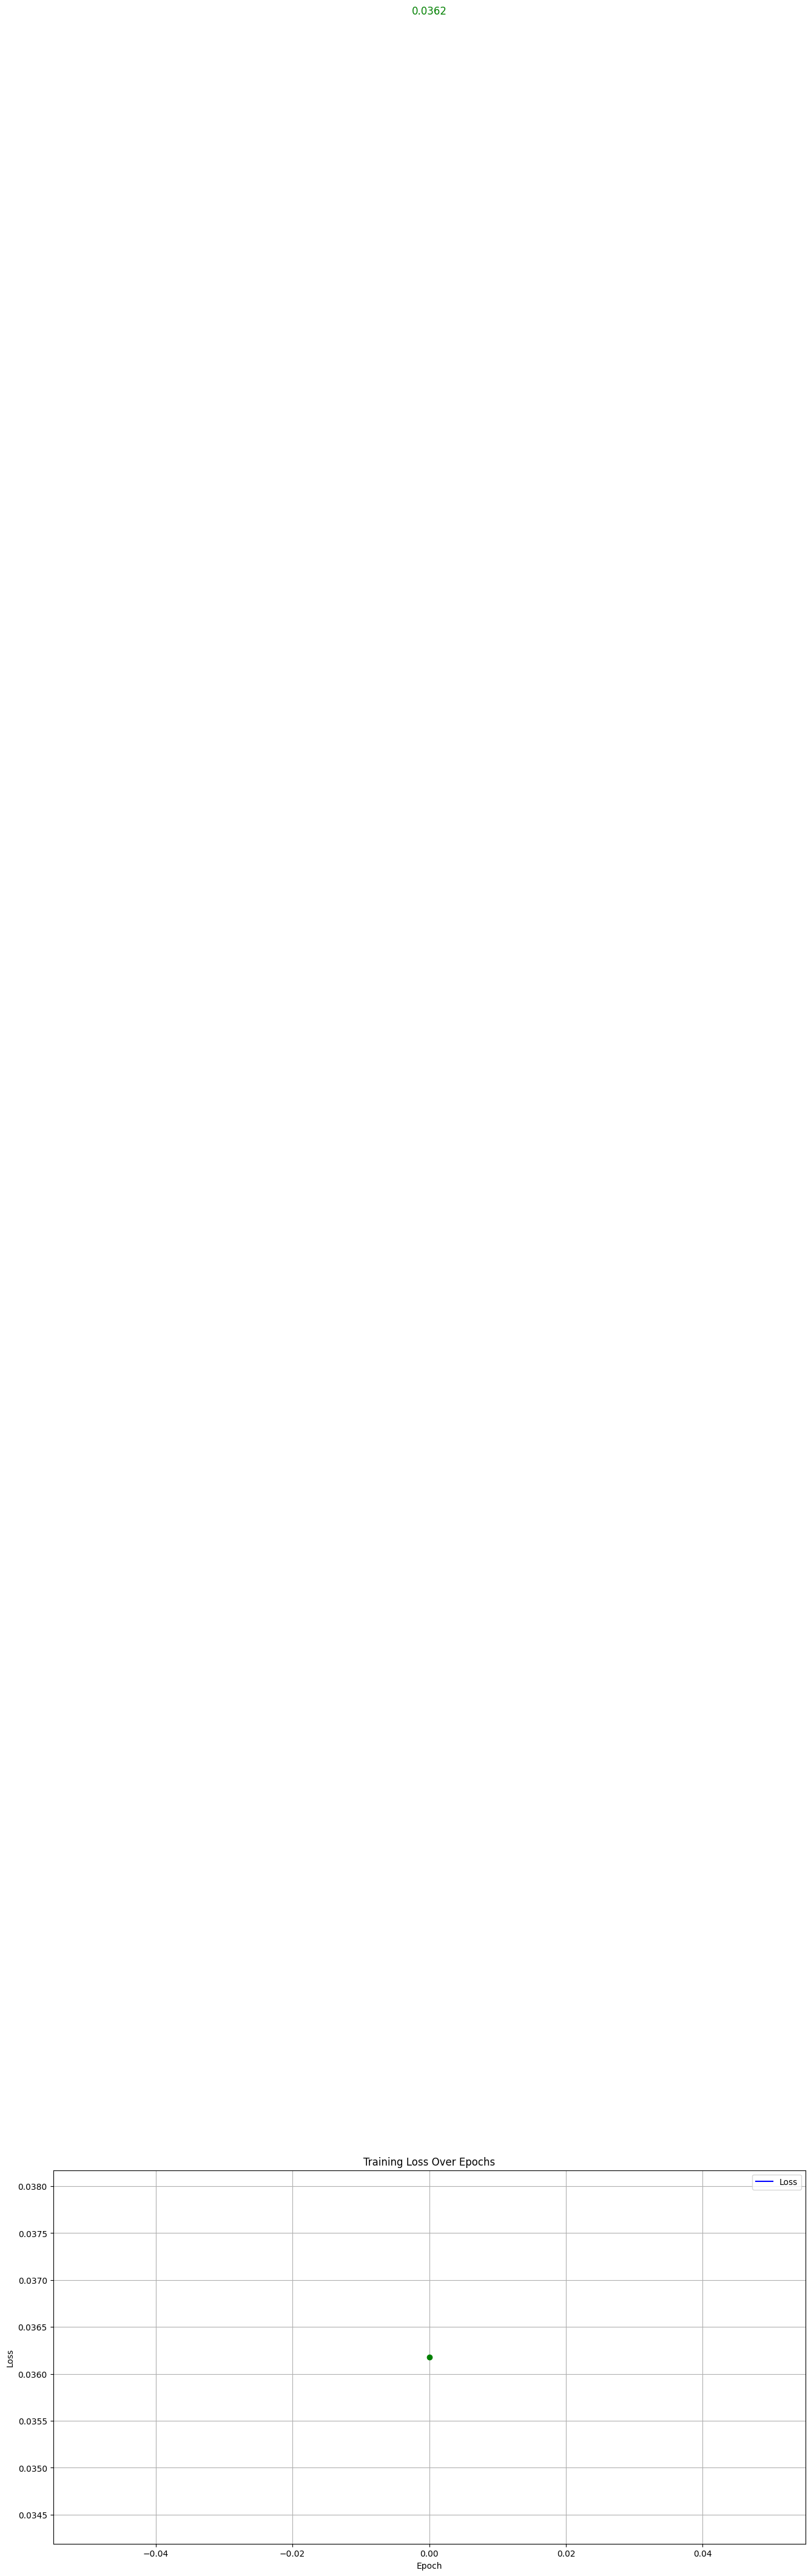

In [13]:
plt.figure(figsize=(16, 8))

plt.plot(losses, label='Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

min_loss = min(losses)
min_loss_epoch = losses.index(min_loss)
plt.scatter(min_loss_epoch, min_loss, color='green', zorder=5)
plt.text(min_loss_epoch,
         min_loss+0.025,
         f'{min_loss:.4f}',
         fontsize=12,
         verticalalignment='center',
         horizontalalignment='center',
         color='green')

plt.legend()
plt.grid()
plt.savefig('training_loss.png')
plt.show()


In [14]:
save_path = "./finetuned_unet"
unet.save_pretrained(save_path)

In [16]:

model_id = "./finetuned_unet"

unet = UNet2DConditionModel.from_pretrained(model_id)

# Move models to device
unet = unet.to(device)
unet.eval()
vae = vae.to(device)
vae.requires_grad_(False)
vae.eval()
vae = vae.to(device)
text_encoder = CLIPTextEncoder().to(device)
text_encoder.eval()









CLIPTextEncoder(
  (text_encoder): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=

In [20]:
def generate_image(
    prompt,
    diffusion,       # UNet2DConditionModel đã fine-tune
    vae,             # AutoencoderKL
    text_encoder,    # CLIPTextEncoder (bạn đã định nghĩa, có tokenizer + model)
    scheduler,       # DDPMScheduler
    num_inference_steps=50,
    seed=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
):
    generator = torch.Generator(device=device)
    if seed is not None:
        generator.manual_seed(seed)

    # 1. Encode prompt thành text embeddings
    inputs = text_encoder.tokenizer(
        [prompt],
        padding="max_length",
        truncation=True,
        max_length=text_encoder.text_encoder.config.max_position_embeddings,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        text_embeddings = text_encoder.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state

    # 2. Lấy danh sách timesteps
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps

    # 3. Khởi tạo latent nhiễu ban đầu
    latents = torch.randn((1, 4, LATENTS_HEIGHT, LATENTS_WIDTH), generator=generator, device=device)

    # 4. Khử nhiễu dần bằng UNet + scheduler
    for t in tqdm(timesteps):
        latent_model_input = latents

        with torch.no_grad():
            noise_pred = diffusion(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            ).sample  # UNet2DConditionModel trả về UNet2DOutput

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # 5. Decode latent thành ảnh
    latents = latents / 0.18215
    with torch.no_grad():
        image = vae.decode(latents).sample

    # 6. Đưa về định dạng ảnh chuẩn
    image = (image.clamp(-1, 1) + 1) / 2  # scale từ [-1,1] -> [0,1]
    image = (image * 255).round().to(torch.uint8)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]  # BCHW -> HWC

    return image


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

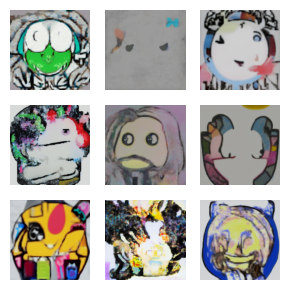

In [21]:
user_inputs = prompts = [
    "a happy blob emoji with sparkling eyes open mouth showing tongue, green skin, floating, purple background",
    "an angry blob emoji with narrowed eyes frowning mouth, orange skin, wearing a party hat, white background",
    "a confused blob emoji with wide eyes slightly open mouth, yellow skin, pointing at his head and wearing a star-shaped crown, dark blue background",
    "a sad blob emoji with droopy eyes frowning mouth, green skin, waving hand and wearing red pom-poms, white background",
    "a grumpy blob emoji with half-closed eyes frowning mouth, purple skin, wielding a large knife, red background",
    "a happy blob emoji with teary eyes smiling mouth, pink skin, wearing a sombrero, white background",
    "a devilish blob emoji with red eyes wide open mouth showing tongue, red skin, wearing horns and hugging a teddy bear, warm background with a fireplace and autumn leaves",
    "a cozy blob emoji with half-closed eyes slightly open mouth, orange skin, holding a steaming cup of coffee and making a fist, warm background with a fireplace and autumn leaves",
    "a surprised blob emoji with wide eyes open mouth, yellow skin, wearing a purple hoodie and sitting on its hind legs, blue background",
]

fig, axes = plt.subplots(3, 3, figsize=(3, 3))
axes = axes.flatten()
for i, user_input in enumerate(user_inputs[:9]):
    prompt = f"A photo of {user_input.lower()}"
    img = generate_image(prompt, unet, vae, text_encoder, scheduler, num_inference_steps=100)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
